In [1]:
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

# path代表读取数据集的路径，默认读取鸢尾花数据集
path = "../data/test1/iris.data"
dataset = pd.read_csv(path, header=None)
# ans表示最后的目标中心点
ans = []
# cu表示最后我们分好类的结果，例如cu[0]表示以ans[0]为中心点的所有元素的一个列表
cu = []
# k表示一共分多少簇，默认为3，threshold表示阈值为多少，times_limit表示最多迭代多少次
k = 3
threshold = 0.0001
times_limit = 20
# kk表示我们对应的每个簇的轮廓系数
kk = []


def choose_dataset():
    global path, dataset
    # print("which dataset do you want?")
    # print("1 to iris, 2 to abalone, ")
    s = eval(input())
    if s == 1:
        path = "../data/test1/iris.data"
        dataset = pd.read_csv(path, header=None)
        dataset = dataset.iloc[:, :-1]
    elif s == 2:
        path = "../data/test1/abalone.data"
        dataset = pd.read_csv(path, header=None)
        dataset = dataset.replace(to_replace=["M", "I", "F"], value=[0, 1, 2])
    elif s == 3:
        path = "../data/test1/seeds_dataset.txt"
        dataset = pd.read_csv(path, header=None, sep='\s+')
    elif s == 4:
        path = "../data/test1/wine.data"
        dataset = pd.read_csv(path, header=None)
    else:
        path = "../data/test1/Wholesale customers data.csv"
        dataset = pd.read_csv(path)
        dataset = dataset.drop(["Channel", "Region"], axis=1)
        # print(dataset.head())
    pca = PCA(n_components=2)
    dataset = pca.fit_transform(dataset)
    dataset = pd.DataFrame(data=dataset, columns=['x', 'y'])


choose_dataset()
print(dataset.head())

          x         y
0 -2.684207  0.326607
1 -2.715391 -0.169557
2 -2.889820 -0.137346
3 -2.746437 -0.311124
4 -2.728593  0.333925


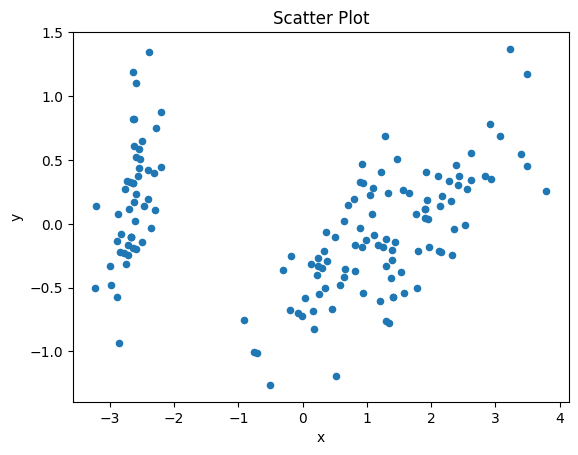

In [2]:
# 画图
dataset.plot(kind='scatter', x='x', y='y')
plt.title('Scatter Plot')
plt.show()

当前测试k值为 2
当前测试k值为 3***************->.]1.02s
当前测试k值为 4***************->.]1.03s
当前测试k值为 5***************->.]1.07s
当前测试k值为 6***************->.]0.99s
当前测试k值为 7***************->.]1.00s
当前测试k值为 8***************->.]0.99s
当前测试k值为 9***************->.]1.22s
当前测试k值为 10**************->.]1.09s


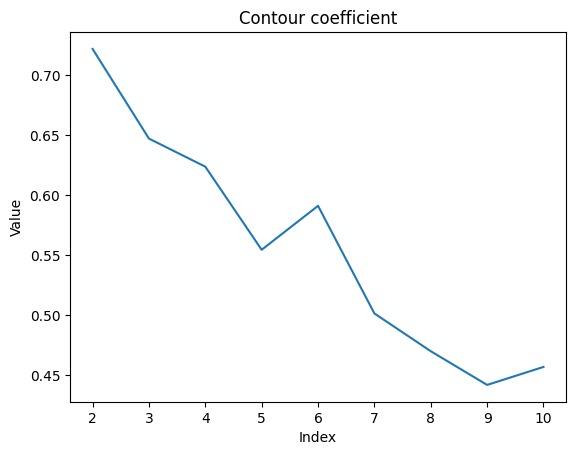

[0.7219384105561565, 0.6471312184168753, 0.6237050928151822, 0.5543632630098214, 0.5910335204835692, 0.501258438960625, 0.46974204538826464, 0.44161821703023263, 0.45662602582546136]
根据上面的结果，我们选择 2 来作为k值


In [6]:
def initialize(ans, k, num_data, cu):
    ans.clear()
    cu.clear()
    temp = random.sample(range(0, num_data), k)
    for i in temp:
        ans.append(dataset.iloc[i].values)
        cu.append([])


def distance(cur, target, status=1):
    # cur和target都是一个一维向量，代表当前的坐标
    # 计算两个点之间的欧拉距离
    # 默认计算欧拉距离，当status为0时表示计算曼哈顿距离
    if status:
        dif = (cur - target) ** 2
        return math.sqrt(np.sum(dif))
    else:
        dif = cur - target
        return np.sum(abs(dif))


def skewing(cur_ans, ans):
    # cur_ans和ans都是二维向量，每一行代表一个坐标
    # 计算当前中心点和上一次中心点之间的偏移量
    dis = 0
    for i in range(len(cur_ans)):
        dis += distance(cur_ans[i], ans[i])
    return dis


def train(dataset):
    # cu用来存储当前这个簇下每个元素的下标号
    # 将我们的簇全部清空用来存放新的分类结果
    for i in range(len(cu)):
        cu[i].clear()
    for i in range(len(dataset)):
        temp = []
        for j in range(len(ans)):
            temp.append(distance(dataset.iloc[i].values, ans[j]))
        # 返回temp中最大的那个元素的下标i，就是距离i中心点最近，归到第i簇中
        cu[temp.index(min(temp))].append(i)
    # 新一轮的簇已经分类完成，现在我们重新计算中心点
    # cur_ans表示我们目前新计算出来的中心点
    cur_ans = ans.copy()
    for i in range(len(cu)):
        # 如果当前的簇没有任何点归到这一类，则直接将之前的中心点赋给cur_ans
        if len(cu[i]) == 0:
            continue
        else:
            cur_ans[i] = [0 for i in range(len(ans[i]))]
            for j in cu[i]:
                # 遍历这个簇中的每个元素
                cur_ans[i] += dataset.iloc[j].values
            # 取平均值
            for j in range(len(cur_ans[i])):
                cur_ans[i][j] /= len(cu[i])
    # print(cu)
    if skewing(cur_ans, ans) > threshold:
        # print(skewing(cur_ans, ans))
        # 表示仍然需要继续迭代，将新的中心点赋值给ans
        for i in range(len(ans)):
            for j in range(len(ans[0])):
                ans[i][j] = cur_ans[i][j]
        # print("仍需迭代")
        return True
    return False


class SC:
    def buxiangsidu(self, cur_data, cur_cu, sign=False):
        # 计算一个样本和一个指定的簇之间的不相似度
        # sign表示是否计算簇内不相似度
        total = 0
        if len(cu[cur_cu]) <= 1:
            return total
        for i in cu[cur_cu]:
            total += distance(dataset.iloc[cur_data].values, dataset.iloc[i].values)
        if sign:
            total /= (len(cu[cur_cu]) - 1)
        else:
            total /= len(cu[cur_cu])
        return total

    def assess(self, cu):
        # 求轮廓系数
        total_si = 0
        start = time.perf_counter()
        scale = len(dataset)
        scale1 = scale / 20
        for i in range(len(dataset)):
            a = int(i / scale1)
            b = 20 - a
            print("\r{:^3.0f}%[{}->{}]{:.2f}s".format(
                (i / scale) * 100, '*' * a, '.' * b, time.perf_counter() - start),
                end="")
            # 计算样本i的轮廓系数
            # 首先计算ai，cur_cu表示该点当前所在簇
            cur_cu = 0
            for j in range(len(cu)):
                if i in cu[j]:
                    cur_cu = j
                    break
            ai = self.buxiangsidu(i, cur_cu, True)
            # 下面计算bi
            total_bi = []
            for j in range(len(cu)):
                # 代表j不属于当前簇
                if j != cur_cu:
                    total_bi.append(self.buxiangsidu(i, j))
            bi = min(total_bi)
            total_si += (bi - ai) / max(ai, bi)
        print("\r", end='')
        total_si /= len(dataset)
        # print("平均轮廓系数为", total_si)
        return total_si


def choose_k():
    global k
    kk.clear()
    for i in range(2, 11):
        k = i
        print("当前测试k值为", k)
        sign = True
        cur_times = 0
        initialize(ans, k, len(dataset), cu)
        while sign and cur_times <= times_limit:
            sign = train(dataset)
            cur_times += 1
        sc = SC()
        result = sc.assess(cu)
        kk.append(result)
    new_index = [i + 2 for i in range(len(kk))]
    plt.plot(new_index, kk)
    plt.title('Contour coefficient')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()
    print(kk)
    k = kk.index(max(kk)) + 2
    print("根据上面的结果，我们选择", k, "来作为k值")


choose_k()

In [7]:
# cur_dis表示当前中心点与上一次中心点的偏移值，cur_times表示目前已迭代多少次
sign = True
cur_times = 0
initialize(ans, k, len(dataset), cu)
while sign and cur_times <= times_limit:
    sign = train(dataset)
    cur_times += 1
print("已经迭代", cur_times, "次")
print("选取的中心点为", ans)
print("最终划分的簇为", cu)
sc = SC()
print("平均轮廓系数为", sc.assess(cu))

已经迭代 7 次
选取的中心点为 [array([-2.62321161,  0.17440573]), array([ 1.37759182, -0.09146294])]
最终划分的簇为 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57, 64, 66, 74, 98, 136], [50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]
平均轮廓系数为 0.734249744772868>.]1.01s


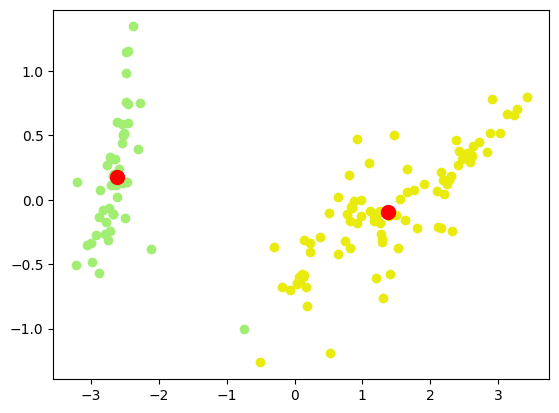

In [11]:
def show_result():
    fig, ax = plt.subplots()
    for i in cu:
        cur_point = dataset.iloc[i]
        color = 'red'
        while color == 'red':
            color = (random.random(), random.random(), random.random())
        ax.scatter(cur_point['x'], cur_point['y'], c=[color])
    cur_point = pd.DataFrame(ans, columns=['x', 'y'])
    ax.scatter(cur_point['x'], cur_point['y'], c='red', s=100)
    plt.show()


show_result()